In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models, transforms

import numpy as np  
import requests

import matplotlib.pyplot as plt
from PIL import Image

In [10]:
torch.cuda.is_available()

True

In [2]:
def url2image(url,file_name):
    content = requests.get(url).content
    file = open(file_name, "bw")
    file.write(content)
    file.close()
    print("[SUCESS] File uploaded")

[SUCESS] File uploaded




---



---





In [ ]:
class DeepDream(nn.Module):
    def __init__(self):
        super(DeepDream, self).__init__()
        self.incetionV3 = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)

    def forward(self, x):
        return self.incetionV3(x)
    

In [ ]:
preprocess = transforms.Compose([
    #transforms.Resize(299),
    #transforms.CenterCrop(299),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
def deep_dream(x, model, lr, loss_fn=-1, class_nb=-1):
    model.eval()

    x.retain_grad()
    out = model(x)

    target = torch.tensor([class_nb])
    #loss = loss_fn(out, target)

    loss = out.float().norm()

    loss.backward()
    model.zero_grad()

    #print(x.data[0][0][0][:10])
    lr_ = lr / np.abs(x.grad.data).mean()
    x.data = x.data + lr_ * x.grad.data
    print(loss.item())
    print(x.data[0][0][0][:10])

    new_image = x.detach().numpy()
    print(new_image.shape)
    new_image = new_image.reshape(new_image.shape[2],new_image.shape[3],3)
    plt.imshow(new_image)
    plt.show()

    return new_image

In [ ]:
model_DeepDream = DeepDream()
lr = 0.02

image = Image.open("dog.jpg")
image_tensor = preprocess(image)
image_tensor = image_tensor.unsqueeze(0)
image_tensor.requires_grad = True
print(image_tensor.shape)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


torch.Size([1, 3, 1213, 1546])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33.10042953491211
tensor([0.0511, 0.0639, 0.0605, 0.0369, 0.0765, 0.0490, 0.0678, 0.0426, 0.0697,
        0.0660])
(1, 3, 1213, 1546)


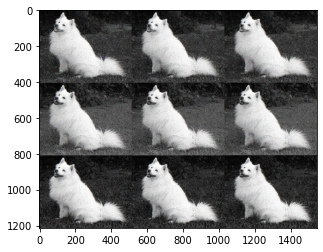

-------------------- 0


AttributeError: ignored

In [ ]:
x = image_tensor
for _ in range(100):
    x = deep_dream(x, model_DeepDream, lr)
    print("-"*20, _)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


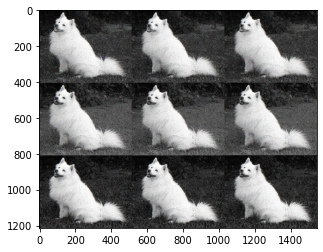

In [ ]:
plt.imshow(image_tensor.detach().numpy().reshape(1213, 1546, 3))



---

---

---





In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd

In [4]:
import numpy as np
import torch
from torchvision import transforms

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])


def deprocess(image_np):
    image_np = image_np.squeeze().transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np


def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

In [5]:
def dream(image, model, iterations, lr):
    """ Updates the image to maximize outputs for n iterations """
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor
    #image = Variable(Tensor(image), requires_grad=True)
    image = torch.tensor(image, requires_grad=True)
    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = out.norm()
        loss.backward()
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
        norm_lr = lr / avg_grad
        image.data += norm_lr * image.grad.data
        image.data = clip(image.data)
        image.grad.data.zero_()
    return image.cpu().data.numpy()


def deep_dream(image, model, iterations, lr, octave_scale, num_octaves):
    """ Main deep dream method """
    image = preprocess(image).unsqueeze(0).cpu().data.numpy()

    # Extract image representations for each octave
    octaves = [image]
    for _ in range(num_octaves - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1 / octave_scale, 1 / octave_scale), order=1))
        print("octaves[-1].shape -- ",(1, 1, 1 / octave_scale, 1 / octave_scale),octaves[-1].shape)
    
    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(tqdm.tqdm(octaves[::-1], desc="Dreaming")):
        if octave > 0:
            # Upsample detail to new octave dimension
            detail = nd.zoom(detail, np.array(octave_base.shape) / np.array(detail.shape), order=1)
        # Add deep dream detail from previous octave to new base
        input_image = octave_base + detail
        # Get new deep dream image
        dreamed_image = dream(input_image, model, iterations, lr)
        # Extract deep dream details
        detail = dreamed_image - octave_base

        plt.imshow(deprocess(dreamed_image))
        plt.show()
        plt.imshow(deprocess(detail))
        plt.show()


        #break #####

    return deprocess(dreamed_image)


In [7]:
at_layer = 10
iterations = 10
lr = 0.01
octave_scale = 1.4
num_octaves = 10



image = Image.open("cat.jpg")

# Define the model
network = models.vgg19(pretrained=True)
layers = list(network.features.children())


#print(network)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Dreaming:   0%|          | 0/5 [00:00<?, ?it/s]

octaves[-1].shape --  (1, 1, 0.7142857142857143, 0.7142857142857143) (1, 3, 536, 714)
octaves[-1].shape --  (1, 1, 0.7142857142857143, 0.7142857142857143) (1, 3, 383, 510)
octaves[-1].shape --  (1, 1, 0.7142857142857143, 0.7142857142857143) (1, 3, 274, 364)
octaves[-1].shape --  (1, 1, 0.7142857142857143, 0.7142857142857143) (1, 3, 196, 260)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


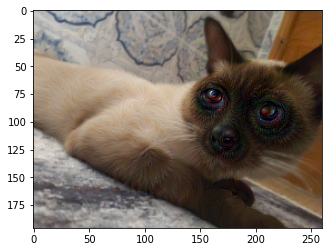

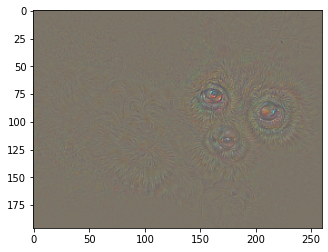


Dreaming:  20%|██        | 1/5 [00:16<01:04, 16.18s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


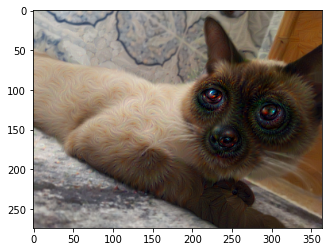

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


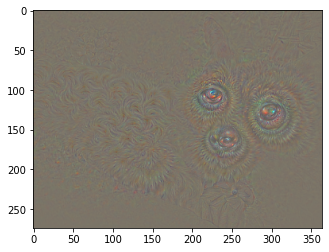


Dreaming:  40%|████      | 2/5 [00:47<01:02, 20.67s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


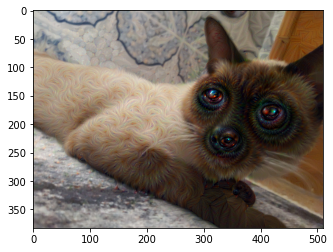

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


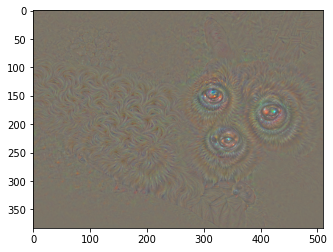


Dreaming:  60%|██████    | 3/5 [01:48<01:05, 32.73s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


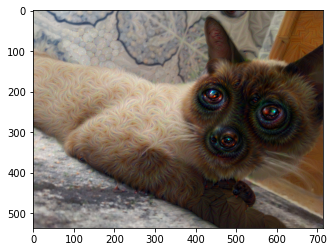

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


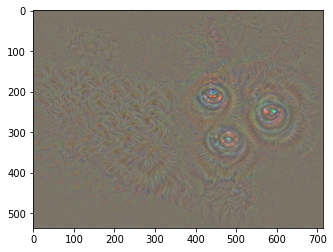


Dreaming:  80%|████████  | 4/5 [03:47<00:58, 58.79s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


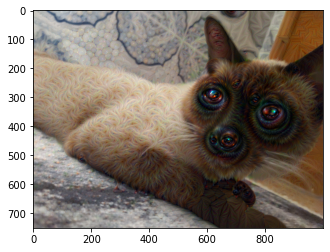

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


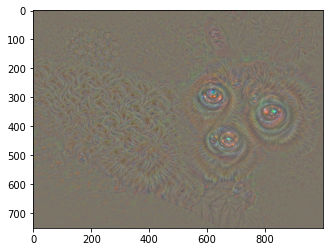


Dreaming: 100%|██████████| 5/5 [07:43<00:00, 92.76s/it] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


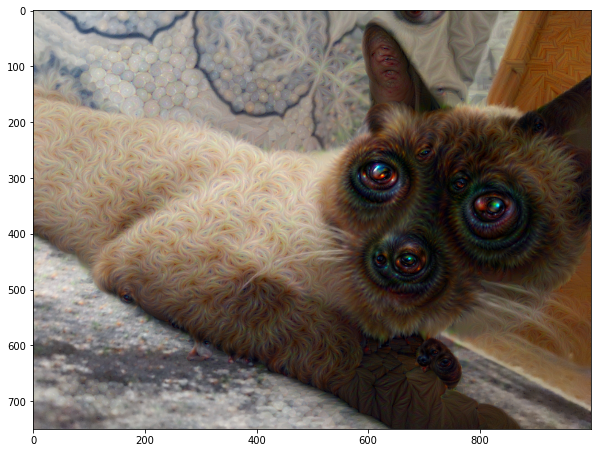

In [13]:
at_layer = 25
iterations = 10
lr = 0.01
octave_scale = 1.4
num_octaves = 5


model = nn.Sequential(*layers[: (at_layer + 1)])
# Extract deep dream image
dreamed_image = deep_dream(
    image,
    model,
    iterations=iterations,
    lr=lr,
    octave_scale=octave_scale,
    num_octaves=num_octaves,
)

# Save and plot image
##os.makedirs("outputs", exist_ok=True)
##filename = args.input_image.split("/")[-1]
plt.figure(figsize=(10, 10))
plt.imshow(dreamed_image)
##plt.imsave(f"outputs/output_{filename}", dreamed_image)
plt.show()